<i><b>Public AI</b></i>

# Optimizer (2) RMSProp and Adam

### _Objective_
* RMSProp Optimizer에 대해 배워보겠습니다. <br>
* 가장 많이 쓰이는 Adam Optimizer에 대해 배워보겠습니다. <br>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

np.random.seed(30)
if "set_random_seed" in dir(tf.random):
    tf.random.set_random_seed(30)
else:
    tf.random.set_seed(30)    

<br><br>

# \[ 1. RMSProp와 Adam Optimizer이란? \]

----

* RMSProp 알고리즘도 모멘텀 알고리즘과 다른 방식으로 Gradient Descent 알고리즘에
지수이동평균 수식을 포함한 수식입니다.
* Adam 알고리즘은 RMSProp 알고리즘과 Momentum 알고리즘을 결합한 수식입니다.

## 0. Gradient Descent Optimizer 수식
$$
W := W - \alpha \frac{\partial Loss}{\partial W}
$$

원래 경사하강법의 수식은 위와 같습니다. 이 수식이 어떻게 변형되는지를 한번 보도록 하겠습니다.

<br>

## 1. RMSProp Optimizer 수식


$$
G_{t+1} = \beta G_{t} + (\triangledown_{W}J(W_t))^2\\
W_{t+1} = W_{t} - \frac{\alpha}{\sqrt{G_{t+1}+\epsilon}}\cdot \triangledown_{W}J(W_t)
$$
* RMSProp은 이전까지 변화해왔던 크기만큼을 나누어줌으로써, 많이 변화한 weight는 세밀하게 조정하도록, 적게 변화한 weight은 크게 조정하도록 설계되었습니다. <br>
* 학습 Step에 따라, 변화하는 크기를 조정하기 때문에 적응적 학습률(Adaptive Learning)이라고도 불립니다. <br>

![](https://mlfromscratch.com/content/images/2019/12/rmsprop.gif)

<br>

## 2. ADAM Optimizer 수식


$$
m_{t+1} = \beta_1 m_{t} + (1-\beta_1)\triangledown_{w}J(w)\\
v_{t+1} = \beta_2 v_{t} + (1-\beta_2)(\triangledown_{w}J(w))^2\\
\hat m_{t+1} = \frac{m_{t+1}}{1-\beta^t_1}\\
\hat v_{t+1} = \frac{v_{t+1}}{1-\beta^t_2}\\
w_{t+1} = w_{t} - \frac{\alpha}{\sqrt{\hat v_t + \epsilon}}\hat m_{t+1}
$$
* Adam 알고리즘은 Momentum알고리즘과 RMSProp 알고리즘을 합쳤습니다.<br>
* 이때 지수보정 수식은 지수 편향식과 $(1-\beta)$ 가중치를 모두 포함한 수식입니다.<br>
* 보통 $\beta_1$로는 0.9, $\beta_2$로는 0.999, $\epsilon$ 으로는 $10^{-8}$ 정도의 값을 사용합니다.

## 3. Optimizer의 계보
---
출처 : 하용호, 자습해도 모르겠던 딥러닝, 머리속에 인스톨 시켜드립니다

![Imgur](https://i.imgur.com/gjdZ0S5.jpg)

<br><br>

# \[ 2. RMSProp와 Adam Optimizer 시각화하기 \]

----


##  Beale Function Visualization


* 최적화 함수(Optimizer)를 평가하기 위해, 보통 Beale Function과 같은 test function을 많이 이용합니다.

$$
f(w_1,w_2) = (1.5 - w_1 + w_1w_2)^2+(2.25-w_1+w_1w_2^2)^2+(2.625-w_1+w_1w_2^3)^2
$$

In [2]:
def beale(w1, w2):
    return ((1.5 - w1 + w1 * w2) ** 2 + 
            (2.25 - w1 + w1 * w2 ** 2) ** 2 + 
            (2.625 - w1 + w1 * w2 ** 3) ** 2)

In [3]:
def generate_beale_plot():
    # Beale function을 공간으로 치환한 것을 
    xmin, xmax, xstep = -4.5, 4.5, .2
    ymin, ymax, ystep = -4.5, 4.5, .2

    w1s = np.arange(xmin, xmax, xstep)
    w2s = np.arange(ymin, ymax, ystep)

    w1, w2 = np.meshgrid(w1s, w2s)
    z = beale(w1, w2)

    minima = np.array([3., .5])
    minima_ = minima.reshape(-1, 1)
    z_minima = beale(*minima)

    plt.figure(figsize=(8, 5))
    ax = plt.axes(projection='3d', elev=50, azim=-50)

    ax.plot(*minima_, z_minima, 'r*', markersize=10)
    ax.plot_surface(w1, w2, z, norm=LogNorm(), rstride=1, cstride=1,
                    edgecolor='None', alpha=0.3, cmap=plt.cm.jet)

    ax.view_init(30, 10)
    ax.set_title("Beale Function Visualization")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    return ax

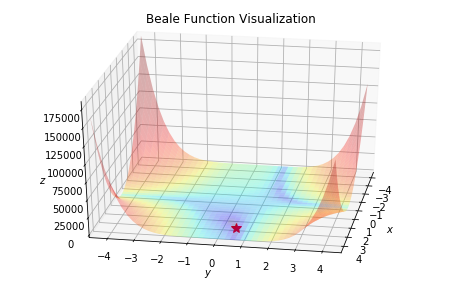

In [4]:
ax = generate_beale_plot()

## 1. RMSProp Optimizer 시각화하기

### (1) decay가 0.9일 때 시각화

In [5]:
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras import backend as K

In [26]:
decay = 0.9
optimizer = RMSprop(learning_rate=1., decay=decay)

start_w1, start_w2 = -2.5, -4.

w1 = K.variable(start_w1)
w2 = K.variable(start_w2)

history = []
for i in tqdm(range(300)):
    with tf.GradientTape() as tape:
        out = beale(w1, w2)
    history.append((w1.numpy(), w2.numpy(), out.numpy()))
    
    variables = [w1, w2]
    gradients = tape.gradient(out, variables)
    optimizer.apply_gradients(zip(gradients, variables))

100%|██████████| 300/300 [00:01<00:00, 218.04it/s]


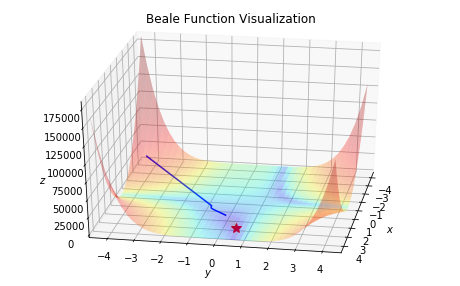

In [27]:
gd_xs, gd_ys, gd_zs = zip(*history)

ax = generate_beale_plot()
ax.plot(gd_xs, gd_ys, gd_zs, 
        label='RMSP(decay={})'.format(decay), 
        color='b')
plt.show()

### (2) decay에 따른 변화

100%|██████████| 300/300 [00:01<00:00, 211.92it/s]


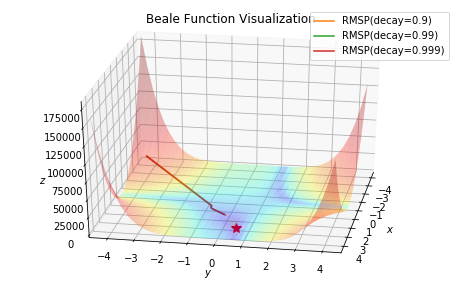

In [28]:
ax = generate_beale_plot()

for decay in [0.9,0.99,0.999]:
    optimizer = RMSprop(learning_rate=1., decay=decay)

    start_w1, start_w2 = -2.5, -4.

    w1 = K.variable(start_w1)
    w2 = K.variable(start_w2)

    history = []
    for i in tqdm(range(300)):
        with tf.GradientTape() as tape:
            out = beale(w1, w2)
        history.append((w1.numpy(), w2.numpy(), out.numpy()))

        variables = [w1, w2]
        gradients = tape.gradient(out, variables)
        optimizer.apply_gradients(zip(gradients, variables))

    gd_xs, gd_ys, gd_zs = zip(*history)
    ax.plot(gd_xs, gd_ys, gd_zs, 
            label='RMSP(decay={})'.format(decay))
plt.legend()
plt.show()

## 2. ADAM Optimizer 시각화하기

### (1)  Adam optimizer 시각화

In [30]:
from tensorflow.keras.optimizers import Adam

In [31]:
optimizer = Adam(learning_rate=1.)

start_w1, start_w2 = -2.5, -4.

w1 = K.variable(start_w1)
w2 = K.variable(start_w2)

history = []
for i in tqdm(range(300)):
    with tf.GradientTape() as tape:
        out = beale(w1, w2)
    history.append((w1.numpy(), w2.numpy(), out.numpy()))
    
    variables = [w1, w2]
    gradients = tape.gradient(out, variables)
    optimizer.apply_gradients(zip(gradients, variables))

100%|██████████| 300/300 [00:01<00:00, 269.86it/s]


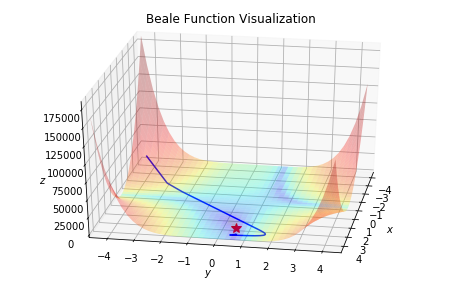

In [33]:
gd_xs, gd_ys, gd_zs = zip(*history)

ax = generate_beale_plot()
ax.plot(gd_xs, gd_ys, gd_zs, 
        label='RMSP(decay={})'.format(decay), 
        color='b')
plt.show()

### (2) Learning Rate에 따른 변화

100%|██████████| 300/300 [00:01<00:00, 239.64it/s]


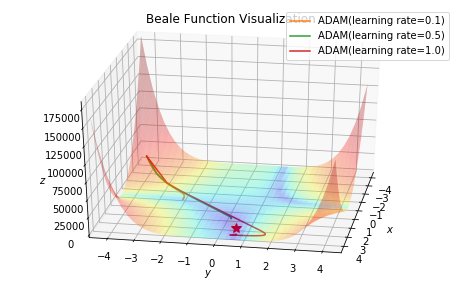

In [39]:
ax = generate_beale_plot()
    
for learning_rate in [0.1,0.5,1.]:
    optimizer = Adam(learning_rate)

    start_w1, start_w2 = -2.5, -4.

    w1 = K.variable(start_w1)
    w2 = K.variable(start_w2)

    history = []
    for i in tqdm(range(300)):
        with tf.GradientTape() as tape:
            out = beale(w1, w2)
        history.append((w1.numpy(), w2.numpy(), out.numpy()))

        variables = [w1, w2]
        gradients = tape.gradient(out, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        
        gd_xs, gd_ys, gd_zs = zip(*history)


    ax.plot(gd_xs, gd_ys, gd_zs, 
            label='ADAM(learning rate={})'.format(learning_rate))
plt.legend()
plt.show()

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/05

---